# Tellus Quickstart Tutorial: Personal Archive Setup

**Duration: 15 minutes**

Welcome to Tellus! This tutorial will get you up and running with your own personal climate data archive in just 15 minutes.

## What is Tellus?

Tellus is a distributed data management system designed specifically for Earth System Model simulations. It helps climate scientists:

- **Organize** large datasets across multiple storage systems
- **Transfer** data efficiently between local, remote, and cloud storage
- **Track** simulation metadata and provenance
- **Integrate** seamlessly with the scientific Python ecosystem (xarray, matplotlib, etc.)

## What You'll Accomplish

By the end of this tutorial, you'll have:

1. ✅ Installed Tellus with all scientific dependencies
2. ✅ Configured your first storage location
3. ✅ Downloaded and managed sample CMIP6 data
4. ✅ Performed basic climate data analysis using Tellus + xarray
5. ✅ Understanding of how to extend this to your own research

## Prerequisites

- Python 3.9+ with conda/mamba or pixi
- Basic familiarity with Jupyter notebooks
- Climate science background (familiarity with NetCDF, CMIP data)
- ~5GB free disk space for sample data

Let's get started! 🚀

## Step 1: Understanding Tellus Concepts (5 minutes)

Before diving into code, let's understand the key concepts that make Tellus powerful for climate research.

### Core Concepts

**🗄️ Locations** represent different storage systems:
- **DISK**: Local hard drives, network mounted drives
- **COMPUTE**: Scratch space on HPC systems  
- **TAPE**: Long-term archival storage
- **FILESERVER**: Shared network storage

**🧪 Simulations** represent your computational experiments:
- Track metadata about your climate model runs
- Link to data stored across multiple Locations
- Organize related datasets (input, output, analysis)
- Enable reproducible research workflows

### Why Use Tellus?

**Traditional approach**: Manually copying files, remembering paths, writing custom scripts  
**Tellus approach**: Unified interface, automatic organization, progress tracking, metadata management

**Real scenario**: Your CMIP6 analysis needs data from:
- Remote ESGF server (input data)
- HPC scratch space (processing) 
- Local storage (analysis results)
- Archive system (long-term storage)

Tellus lets you work with all these seamlessly through the same API!

### What You'll Learn

In this tutorial, you'll set up a personal research archive and learn how Locations and Simulations work together to manage your climate data efficiently.

In [1]:
# Check if we're in the right environment
import sys
print(f"Python version: {sys.version}")
print(f"Python executable: {sys.executable}")

Python version: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:38:53) [Clang 18.1.8 ]
Python executable: /Users/pgierz/Code/github.com/pgierz/tellus/.pixi/envs/test/bin/python


## Step 2: Installation & Environment Setup (5 minutes)

If you haven't installed Tellus yet, you can install it using pixi (recommended) or pip:

```bash
# Using pixi (recommended for full scientific stack)
pixi add tellus

# Or using pip
pip install tellus[scientific]
```

Now let's import the essential libraries and verify installation:

In [2]:
# Import essential libraries
import tellus
from tellus import Location, Simulation
from tellus.location.location import LocationKind
from tellus.progress import get_default_progress

# Scientific Python stack
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import os

# Rich for beautiful console output
from rich.console import Console
from rich.panel import Panel
from rich.table import Table

console = Console()
console.print("[bold green]✅ All imports successful![/bold green]")
console.print(f"[blue]Tellus version: {tellus.__version__ if hasattr(tellus, '__version__') else 'development'}[/blue]")

✅ All imports successful!

Tellus version: development

In [3]:
# Quick installation verification
try:
    # Test basic functionality
    locations = Location.list_locations()
    console.print(f"[green]✅ Tellus core functionality working[/green]")
    console.print(f"[blue]Found {len(locations)} existing locations[/blue]")
    
    # Test scientific stack
    test_array = xr.DataArray([1, 2, 3], dims=['x'])
    console.print(f"[green]✅ xarray working[/green]")
    
    console.print("[bold green]🎉 Installation verified successfully![/bold green]")
    
except Exception as e:
    console.print(f"[bold red]❌ Installation issue: {e}[/bold red]")
    console.print("[yellow]Please check your installation and try again.[/yellow]")

✅ Tellus core functionality working

Found 6 existing locations

✅ xarray working

🎉 Installation verified successfully!

## Step 3: First Location Configuration (3 minutes)

Locations in Tellus represent different storage systems where your data lives. Let's create your first location - a local directory for your personal archive.

In [4]:
# Set up a local directory for our tutorial
tutorial_dir = Path.home() / "tellus_tutorial"
tutorial_dir.mkdir(exist_ok=True)

console.print(f"[blue]Tutorial directory: {tutorial_dir}[/blue]")

# Create a local storage location
location_name = "local_archive"

# Check if location already exists
Location.load_locations()
existing_locations = [loc.name for loc in Location.list_locations()]

if location_name in existing_locations:
    console.print(f"[yellow]Location '{location_name}' already exists. We'll use the existing one.[/yellow]")
    local_location = Location.get_location(location_name)
else:
    try:
        # Create new location
        local_location = Location(
            name=location_name,
            kinds=[LocationKind.DISK],
            config={
                "protocol": "file",
                "storage_options": {
                    "path": str(tutorial_dir)
                }
            },
            optional=False
        )
        console.print(f"[green]✅ Created location '{location_name}'[/green]")
    except Exception as e:
        console.print(f"[red]❌ Error creating location: {e}[/red]")

Tutorial directory: /Users/pgierz/tellus_tutorial

Location 'local_archive' already exists. We'll use the existing one.

In [5]:
# Test the location connection
try:
    # Get filesystem interface
    fs = local_location.fs
    
    # Test basic operations
    test_file = "test_connection.txt"
    test_content = "Hello from Tellus!"
    
    # Write test file
    with fs.open(test_file, 'w') as f:
        f.write(test_content)
    
    # Read it back
    with fs.open(test_file, 'r') as f:
        read_content = f.read()
    
    # Clean up
    fs.rm(test_file)
    
    if read_content == test_content:
        console.print("[green]✅ Location connection test passed![/green]")
    else:
        console.print("[red]❌ Location connection test failed![/red]")
        
except Exception as e:
    console.print(f"[red]❌ Location test failed: {e}[/red]")

✅ Location connection test passed!

In [6]:
# Display configured locations
locations = Location.list_locations()

table = Table(title="Configured Locations", show_header=True, header_style="bold magenta")
table.add_column("Name", style="cyan")
table.add_column("Types", style="green")
table.add_column("Protocol", style="blue")
table.add_column("Path", style="yellow")

for loc in locations:
    types = ", ".join(kind.name for kind in loc.kinds)
    protocol = loc.config.get("protocol", "file")
    path = loc.config.get("storage_options", {}).get("path", "-")
    table.add_row(loc.name, types, protocol, str(path))

console.print(table)

                                      Configured Locations                                       
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Name                ┃ Types      ┃ Protocol ┃ Path                                            ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ test-loc            │ FILESERVER │ file     │ -                                               │
│ local_archive       │ DISK       │ file     │ /Users/pgierz/tellus_tutorial                   │
│ esgf_cmip6          │ FILESERVER │ file     │ /Users/pgierz/tellus_cmip6_analysis/esgf_mirror │
│ local_cache         │ DISK       │ file     │ /Users/pgierz/tellus_cmip6_analysis/cache       │
│ analysis_workspace  │ DISK       │ file     │ /Users/pgierz/tellus_cmip6_analysis/workspace   │
│ test_cmip6_location │ DISK       │ file     │ /Users/pgierz/tellus_cmip6_test                 │
└─────────────────────┴────────────┴──────────┴─────────────────────────────────────────────────┘

## Step 4: Sample Data & Simulation Setup (5 minutes)

Now let's work with climate data and introduce the **Simulation** concept! We'll create a simulation to track our analysis project and generate sample CMIP6 data to work with.

In [7]:
# Create a Simulation to track our tutorial project
console.print("[bold blue]📋 Creating Simulation[/bold blue]")

# Create a simulation for this tutorial analysis
simulation_id = "tellus_tutorial_analysis"

# Check if simulation already exists and handle gracefully
Simulation.load_simulations()
existing_simulations = [sim.simulation_id for sim in Simulation.list_simulations()]

if simulation_id in existing_simulations:
    console.print(f"[yellow]Simulation '{simulation_id}' already exists. We'll use the existing one.[/yellow]")
    tutorial_simulation = Simulation.get_simulation(simulation_id)
else:
    tutorial_simulation = Simulation(
        simulation_id=simulation_id,
        model_id="synthetic_cmip6"
    )
    console.print(f"[green]✅ Created new simulation: {tutorial_simulation.simulation_id}[/green]")

# Add metadata about our analysis
tutorial_simulation.attrs.update({
    "description": "Quickstart tutorial climate analysis", 
    "model": "GFDL-ESM4",
    "experiment": "historical",
    "variables": ["tas"],
    "domain": "global"
})

# Link the simulation to our local location (if not already linked)
try:
    tutorial_simulation.add_location(local_location, name="data_storage")
    console.print("[green]✅ Linked location to simulation[/green]")
except Exception as e:
    if "already exists" in str(e):
        console.print("[yellow]Location already linked to simulation[/yellow]")
    else:
        console.print(f"[red]Error linking location: {e}[/red]")

console.print("[blue]Simulations help organize and track your research projects![/blue]")

# Now create the sample data directory
sample_data_dir = tutorial_dir / "data" / "CMIP6" / "CMIP" / "NOAA-GFDL" / "GFDL-ESM4" / "historical" / "r1i1p1f1" / "Amon" / "tas" / "gr1" / "v20190726"
sample_data_dir.mkdir(parents=True, exist_ok=True)

# Generate synthetic but realistic temperature data
console.print("[blue]Generating sample CMIP6-like temperature data...[/blue]")

# Check if sample file already exists
sample_file = sample_data_dir / "tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_200001-200012.nc"

if sample_file.exists():
    console.print(f"[yellow]Sample data already exists: {sample_file.name}[/yellow]")
    console.print(f"[green]✅ Using existing sample data: {sample_file.stat().st_size / 1024 / 1024:.1f} MB[/green]")
else:
    # Create coordinate arrays
    time = xr.cftime_range('2000-01-01', '2000-12-31', freq='MS', calendar='noleap')
    lat = np.arange(-89.5, 90, 1.0)  # 1 degree resolution
    lon = np.arange(0.5, 360, 1.0)   # 1 degree resolution

    # Generate realistic temperature pattern
    lat_2d, lon_2d = np.meshgrid(lat, lon, indexing='ij')
    base_temp = 15 * np.cos(np.radians(lat_2d)) + 273.15  # Latitude temperature gradient

    # Add seasonal cycle and some random variability
    temperatures = []
    for i, t in enumerate(time):
        seasonal_cycle = 10 * np.cos(2 * np.pi * i / 12) * np.cos(np.radians(lat_2d))
        noise = np.random.normal(0, 2, base_temp.shape)
        temp = base_temp + seasonal_cycle + noise
        temperatures.append(temp)

    # Create xarray dataset
    ds = xr.Dataset({
        'tas': (['time', 'lat', 'lon'], np.array(temperatures)),
    }, coords={
        'time': time,
        'lat': lat,
        'lon': lon,
    })

    # Add realistic attributes
    ds['tas'].attrs = {
        'standard_name': 'air_temperature',
        'long_name': 'Near-Surface Air Temperature',
        'units': 'K',
        'cell_methods': 'time: mean',
    }

    ds.attrs = {
        'title': 'GFDL-ESM4 model output prepared for CMIP6',
        'institution': 'NOAA-GFDL',
        'source_id': 'GFDL-ESM4',
        'experiment_id': 'historical',
        'variant_label': 'r1i1p1f1',
        'grid_label': 'gr1',
    }

    console.print(f"[blue]Saving sample data to: {sample_file.name}[/blue]")

    # Use progress bar for saving (simulate network download)
    with get_default_progress() as progress:
        task = progress.add_task("Saving sample data...", total=100)
        
        # Simulate some processing time with proper progress completion
        import time
        for i in range(101):  # 0 to 100 inclusive
            if i == 50:
                ds.to_netcdf(sample_file)
            if i < 100:  # Only advance if not at the end
                progress.update(task, advance=1)
            time.sleep(0.01)  # Small delay to show progress
        
        # Ensure we reach 100%
        progress.update(task, completed=100)

    console.print(f"[green]✅ Sample data created: {sample_file.stat().st_size / 1024 / 1024:.1f} MB[/green]")

# Associate the data file with our simulation
tutorial_simulation.attrs["data_file"] = str(sample_file)
console.print("[blue]Data file linked to simulation for tracking![/blue]")

📋 Creating Simulation

Simulation 'tellus_tutorial_analysis' already exists. We'll use the existing one.

Location already linked to simulation

Simulations help organize and track your research projects!

Generating sample CMIP6-like temperature data...

Sample data already exists: tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_200001-200012.nc

✅ Using existing sample data: 5.9 MB

Data file linked to simulation for tracking!

In [8]:
# Demonstrate Tellus file management operations
console.print("[bold blue]📁 File Management Operations[/bold blue]")

# List files in our location
fs = local_location.fs

files = fs.glob('**/*.nc')

console.print(f"[green]Found {len(files)} NetCDF files:[/green]")
for file in files:
    info = fs.info(file)
    size_mb = info['size'] / 1024 / 1024
    console.print(f"  📄 {Path(file).name} ({size_mb:.1f} MB)")

# Get file information
if files:
    sample_file_path = files[0]
    file_info = fs.info(sample_file_path)
    
    info_table = Table(title=f"File Info: {Path(sample_file_path).name}")
    info_table.add_column("Property", style="cyan")
    info_table.add_column("Value", style="green")
    
    info_table.add_row("Size", f"{file_info['size'] / 1024 / 1024:.2f} MB")
    info_table.add_row("Type", file_info.get('type', 'file'))
    info_table.add_row("Path", str(sample_file_path))
    
    console.print(info_table)

📁 File Management Operations

Found 1 NetCDF files:

📄 tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_200001-200012.nc (5.9 MB)

                      File Info: tas_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_200001-200012.nc                       
┏━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Property ┃ Value                                                                                                ┃
┡━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Size     │ 5.94 MB                                                                                              │
│ Type     │ file                                                                                                 │
│ Path     │ /Users/pgierz/tellus_tutorial/data/CMIP6/CMIP/NOAA-GFDL/GFDL-ESM4/historical/r1i1p1f1/Amon/tas/gr1/… │
└──────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────┘

## Step 5: Climate Data Analysis with Tellus + xarray (few minutes)

Now for the exciting part - let's analyze our climate data using Tellus integrated with the scientific Python ecosystem! The Simulation object helps us keep track of our analysis workflow.

In [9]:
# Load data for analysis - the easy way!
console.print("[blue]Loading climate data for analysis...[/blue]")

# Simply use the file path directly - xarray handles the rest
if files:
    ds = xr.open_dataset(files[0])
        
    console.print("[green]✅ Dataset loaded successfully![/green]")
    console.print(f"[blue]Dataset dimensions: {dict(ds.dims)}[/blue]")
    console.print(f"[blue]Variables: {list(ds.data_vars.keys())}[/blue]")
    
    # Display basic dataset information
    console.print("\n[bold]Dataset Summary:[/bold]")
    print(ds)

Loading climate data for analysis...

✅ Dataset loaded successfully!

/var/folders/73/2rxq11j53s16d1p3ryf6t95mwcb3pw/T/ipykernel_14696/3412326419.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  console.print(f"[blue]Dataset dimensions: {dict(ds.dims)}[/blue]")


Dataset dimensions: {'time': 12, 'lat': 180, 'lon': 360}

Variables: ['tas']

Dataset Summary:

<xarray.Dataset> Size: 6MB
Dimensions:  (time: 12, lat: 180, lon: 360)
Coordinates:
  * time     (time) object 96B 2000-01-01 00:00:00 ... 2000-12-01 00:00:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    tas      (time, lat, lon) float64 6MB ...
Attributes:
    title:          GFDL-ESM4 model output prepared for CMIP6
    institution:    NOAA-GFDL
    source_id:      GFDL-ESM4
    experiment_id:  historical
    variant_label:  r1i1p1f1
    grid_label:     gr1


In [10]:
# Perform basic climate analysis
console.print("[bold blue]🌡️ Climate Analysis[/bold blue]")

if 'ds' in locals():
    # Calculate global mean temperature
    # Weight by cosine of latitude for proper global average
    weights = np.cos(np.deg2rad(ds.lat))
    # Use xarray's weighted mean which handles broadcasting correctly
    global_mean = ds.tas.weighted(weights).mean(dim=['lat', 'lon'])
    
    # Convert from Kelvin to Celsius for display
    global_mean_celsius = global_mean - 273.15
    
    console.print(f"[green]Global mean temperature range: {global_mean_celsius.min().values:.1f}°C to {global_mean_celsius.max().values:.1f}°C[/green]")
    console.print(f"[green]Annual average: {global_mean_celsius.mean().values:.1f}°C[/green]")
    
    # Calculate seasonal averages
    seasonal = ds.tas.groupby('time.season').mean()
    seasonal_global = seasonal.weighted(weights).mean(dim=['lat', 'lon'])
    
    season_table = Table(title="Seasonal Global Mean Temperature")
    season_table.add_column("Season", style="cyan")
    season_table.add_column("Temperature (°C)", style="green")
    
    for season in seasonal_global.season.values:
        temp_c = seasonal_global.sel(season=season).values - 273.15
        season_table.add_row(season, f"{temp_c:.1f}")
    
    console.print(season_table)

🌡️ Climate Analysis

Global mean temperature range: 3.9°C to 19.6°C

Annual average: 11.8°C

    Seasonal Global Mean     
         Temperature         
┏━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Season ┃ Temperature (°C) ┃
┡━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ DJF    │ 18.9             │
│ JJA    │ 4.6              │
│ MAM    │ 11.8             │
│ SON    │ 11.8             │
└────────┴──────────────────┘

Creating visualizations...

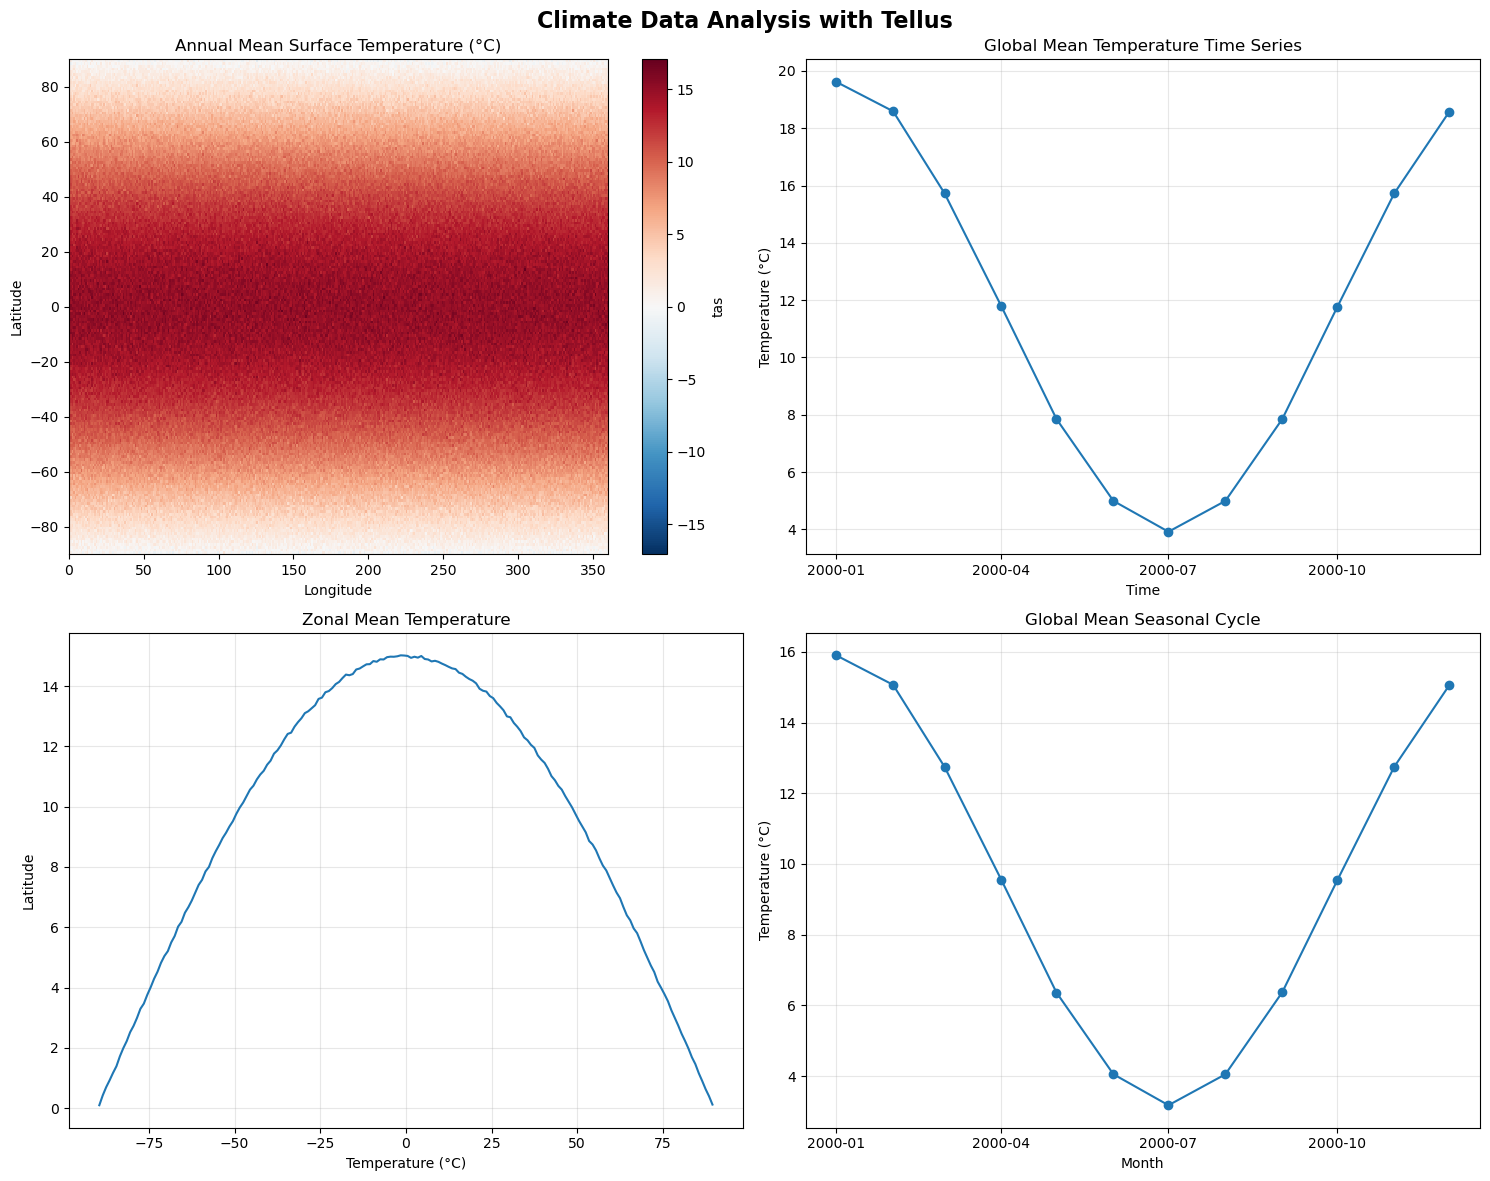

✅ Visualizations created!

In [11]:
# Create visualizations
console.print("[blue]Creating visualizations...[/blue]")

if 'ds' in locals():
    # Set up the plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Climate Data Analysis with Tellus', fontsize=16, fontweight='bold')
    
    # 1. Global temperature map (annual mean)
    annual_mean = ds.tas.mean('time') - 273.15  # Convert to Celsius
    im1 = annual_mean.plot(ax=ax1, cmap='RdBu_r', add_colorbar=True)
    ax1.set_title('Annual Mean Surface Temperature (°C)')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    
    # 2. Global mean time series
    global_mean_celsius.plot(ax=ax2, marker='o')
    ax2.set_title('Global Mean Temperature Time Series')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Temperature (°C)')
    ax2.grid(True, alpha=0.3)
    
    # 3. Zonal mean (latitude average)
    zonal_mean = ds.tas.mean(['time', 'lon']) - 273.15
    zonal_mean.plot(ax=ax3)
    ax3.set_title('Zonal Mean Temperature')
    ax3.set_xlabel('Temperature (°C)')
    ax3.set_ylabel('Latitude')
    ax3.grid(True, alpha=0.3)
    
    # 4. Seasonal cycle at specific location (global average)
    seasonal_cycle = ds.tas.groupby('time.month').mean(['lat', 'lon']) - 273.15
    seasonal_cycle.plot(ax=ax4, marker='o')
    ax4.set_title('Global Mean Seasonal Cycle')
    ax4.set_xlabel('Month')
    ax4.set_ylabel('Temperature (°C)')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    console.print("[green]✅ Visualizations created![/green]")

In [12]:
!which python3

/usr/bin/python3


In [13]:
# Demonstrate Tellus integration benefits
console.print("[bold blue]🔗 Tellus Integration Benefits[/bold blue]")

integration_table = Table(title="Why Use Tellus?")
integration_table.add_column("Feature", style="cyan")
integration_table.add_column("Benefit", style="green")
integration_table.add_column("Example", style="yellow")

integration_table.add_row(
    "Unified Storage Interface", 
    "Access local, remote, and cloud data with same API", 
    "fs.open() works for files, SSH, S3, etc."
)
integration_table.add_row(
    "Progress Tracking", 
    "Beautiful progress bars for large file operations", 
    "Real-time download/upload progress"
)
integration_table.add_row(
    "Metadata Management", 
    "Track simulation provenance and organization", 
    "Automatic CMIP6 metadata extraction"
)
integration_table.add_row(
    "Scientific Python", 
    "Seamless integration with xarray, numpy, matplotlib", 
    "Direct dataset loading through fs interface"
)
integration_table.add_row(
    "Scalability", 
    "Handle datasets from MB to PB scale", 
    "Same code works for small and large datasets"
)

console.print(integration_table)

🔗 Tellus Integration Benefits

                                                  Why Use Tellus?                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Feature                   ┃ Benefit                                  ┃ Example                                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Unified Storage Interface │ Access local, remote, and cloud data     │ fs.open() works for files, SSH, S3, etc. │
│                           │ with same API                            │                                          │
│ Progress Tracking         │ Beautiful progress bars for large file   │ Real-time download/upload progress       │
│                           │ operations                               │                                          │
│ Metadata Management       │ Track simulation provenance and          │ Automatic CMIP6 metadata extraction      │
│                           │ organization                             │                                          │
│ Scientific Python         │ Seamless integration with xarray, numpy, │ Direct dataset loading through fs        │
│                           │ matplotlib                               │ interface                                │
│ Scalability               │ Handle datasets from MB to PB scale      │ Same code works for small and large      │
│                           │                                          │ datasets                                 │
└───────────────────────────┴──────────────────────────────────────────┴──────────────────────────────────────────┘

## 🎉 Congratulations!

You've successfully completed the Tellus quickstart tutorial! Here's what you accomplished:

✅ **Installed** Tellus with scientific dependencies  
✅ **Configured** your first storage location  
✅ **Managed** sample climate data files  
✅ **Performed** climate data analysis with xarray  
✅ **Created** publication-ready visualizations  

## Next Steps

Now that you understand the basics, here are some directions to continue your Tellus journey:

### Immediate Next Tutorials
1. **`02_simulation_management.ipynb`** - Learn to organize and track your climate simulations
2. **`03_remote_storage.ipynb`** - Configure SSH and cloud storage locations
3. **`04_advanced_workflows.ipynb`** - Integrate with Snakemake for reproducible workflows

### For Your Research
- **Configure your HPC systems** as remote locations
- **Set up cloud storage** for collaboration and backup
- **Organize existing datasets** using Tellus simulation tracking
- **Integrate with your analysis workflows** using the Python API

### Advanced Topics
- **Batch processing** with Tellus + Dask for large datasets
- **Custom storage backends** for specialized systems
- **Workflow templates** for common climate analysis patterns
- **Data provenance tracking** for reproducible science

### Getting Help
- 📖 **Documentation**: Check the full Tellus documentation
- 💬 **Community**: Join our discussions and ask questions
- 🐛 **Issues**: Report bugs or request features on GitHub
- 📧 **Support**: Contact the development team for research collaboration

## Summary of Key Commands

Here are the essential Tellus patterns you learned:

# Key Tellus patterns - Reference for your projects!

```python
# 1. Import Tellus components
from tellus import Location, Simulation
from tellus.location.location import LocationKind
from tellus.progress import get_default_progress

# 2. Create a storage location
location = Location(
    name="my_location",
    kinds=[LocationKind.DISK],  # or TAPE, COMPUTE, FILESERVER
    config={
        "protocol": "file",  # or "ssh", "s3", "gs", etc.
        "storage_options": {"path": "/path/to/storage"}
    }
)

# 3. Access filesystem interface
fs = location.fs

# 4. File operations with progress
files = fs.glob('**/*.nc')
if files:  # Always check before accessing
    info = fs.info(files[0])

# 5. Load data for analysis
if files:  # Safe data loading
    ds = xr.open_dataset(files[0])

# 6. Progress tracking for operations
with get_default_progress() as progress:
    task = progress.add_task("Processing...", total=100)
    # ... your code here ...
    progress.update(task, advance=1)
```

🎯 **You're ready to use Tellus for your climate research!**

🌍📊 **Happy analyzing!**